## Bibliotecas

In [1]:
using LinearAlgebra
using Plots
using GaussQuadrature
using SparseArrays

## Definição das f's das equações e suas soluções analíticas 

In [2]:
function f1(x::Float64, α::Float64, β::Float64)
    return -2*α + β*(x^2-x)
end

function u1(x::Float64)
    return x*(x-1)
end

function f2(x::Float64, α::Float64, β::Float64)
    return (α*π^2 + β)*sin(π*x)
end

function u2(x::Float64)
    return sin(π*x)
end

function f3(x::Float64, α::Float64, β::Float64)
    return 8.0::Float64
end

function u3(x::Float64)
    return -4*x*(x-1)::Float64
end

function f4(x::Float64, α::Float64, β::Float64)
    return x::Float64
end

function u4(x::Float64)
    return x + (exp(-x) - exp(x))/(exp(1) - exp(-1)) ::Float64
end

u4 (generic function with 1 method)

## Base

In [3]:
function ϕ₁(ξ)
    return (1.0 - ξ)/2.0 :: Float64
end

function ϕ₂(ξ)
    return (1.0 + ξ)/2.0 :: Float64
end

function dϕ₁(ξ)
    return -1.0/2.0 :: Float64
end

function dϕ₂(ξ)
    return 1.0/2.0 :: Float64
end

dϕ₂ (generic function with 1 method)

## Funções auxiliares

In [4]:
function get_point(index::Int64, m::Int64)
    return convert(Float64, index/(m+1))     
end

function map_ξ_x(ξ, x_i_inf, h)
    return x_i_inf + ((h*(ξ+1))/2.0)
end

function quadratura_F_local(f, ϕ, α, β, e, m)
    pontos, pesos = legendre(5)
    quad = 0
    
    h = 1/(m+1)
    x_i_inf = get_point(e-1, m)
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f(map_ξ_x(ξ, x_i_inf, h), α, β) * ϕ(ξ)) 
    end
    
    return quad
end
    

function quadratura_phis_K(f1, f2)
    pontos, pesos = legendre(5)
    quad = 0
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f1(ξ) * f2(ξ) ) 
    end
    
    return quad
end



quadratura_phis_K (generic function with 1 method)

In [5]:
function monta_LG(ne)
    return transpose(hcat(1:ne, 2:ne+1))
end

function monta_EQ(ne)
    m = ne-1
    return vcat(m+1, 1:m, m+1)
end

function monta_F_local(f, α, β, m, e)
    h = 1/(m+1)
    
    F_local = zeros(2)
    F_local[1] = h/2 * quadratura_F_local(f, ϕ₁, α, β, e, m)
    F_local[2] = h/2 * quadratura_F_local(f, ϕ₂, α, β, e, m)

    return F_local    
end

function monta_K_local(α, β, m)
    h = 1/(m+1)
    K_local = zeros(2, 2)
    
    K_local[1, 1] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₁) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₁)
    K_local[1, 2] = K_local[2, 1] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₂)
    K_local[2, 2] = (2*α/h) * quadratura_phis_K(dϕ₂, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₂, ϕ₂)    
    
    return K_local
end

function monta_F_global(f, α, β, ne, EQoLG)
    m = ne-1
    F_global = zeros(m+1)

    for e in 1:m+1
        F_local = monta_F_local(f, α, β, m, e)
        for i in 1:2
            index = EQoLG[i, e]
            F_global[index] += F_local[i]
        end
    end
    
    return F_global[1:m]
end

function monta_K_global(α, β, ne, EQoLG)
    m = ne-1
    K_global = spzeros(m+1,m+1)
    K_local = monta_K_local(α, β, m)
    
    for e in 1:m+1
        for i in 1:2
            for j in 1:2
                i_global = EQoLG[i, e]
                j_global = EQoLG[j, e]
                
                K_global[i_global, j_global] += K_local[i, j]
            end
        end
    end
    
    
    return K_global[1:m, 1:m]
    
end

monta_K_global (generic function with 1 method)

In [7]:
function monta_uh(c)    
    return vcat(0, c, 0)
end

monta_uh (generic function with 1 method)

In [15]:
function erro_L2(u, c̄, ne)
    m = ne-1
    h = 1/(m+1)
    
    pontos, pesos = legendre(5)
    erro_quadrado = 0

    for e in 1:ne
        x_i_inf = get_point(e-1, m)

        for (ξ, W) in zip(pontos, pesos)
            erro_quadrado += W * (u(map_ξ_x(ξ, x_i_inf, h)) - c̄[e]*ϕ₁(ξ) - c̄[e+1]*ϕ₂(ξ))^2 
        end
    end
    
    return sqrt(erro_quadrado * h/2)    
end

erro_L2 (generic function with 1 method)

In [17]:
function estudo_convergencia(n_testes, f, u, α, β)
    ne_list = 2 .^ (2:n_testes) 
    h_list = []
    erros = []
    
    for ne in ne_list
        m = ne-1
        h = 1/(m+1)
        
        LG = monta_LG(ne)
        EQ = monta_EQ(ne)
        EQoLG = EQ[LG]
        
        K = monta_K_global(α, β, ne, EQoLG)
        F = monta_F_global(f4, α, β, ne, EQoLG)

        c = K\F
        uh = monta_uh(c)
        
        erro = erro_L2(u, uh, ne)
        push!(erros, erro)
        push!(h_list, h)        
    end

    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft)
end

estudo_convergencia (generic function with 1 method)

In [16]:
α = 1.0
β = 1.0
ne = 4

LG = monta_LG(ne)
EQ = monta_EQ(ne)

EQoLG = EQ[LG]
display(EQoLG)

K = monta_K_global(α, β, ne, EQoLG)
display(K)

F = monta_F_global(f4, α, β, ne, EQoLG)
display(F)

c = K\F
display(c)

uh = monta_uh(c)
display(uh)

display(u4.(get_point.(0:ne, ne-1)))

erro_L2(u4, uh, ne)

2×4 Matrix{Int64}:
 4  1  2  3
 1  2  3  4

3×3 SparseMatrixCSC{Float64, Int64} with 7 stored entries:
  8.16667  -3.95833    ⋅ 
 -3.95833   8.16667  -3.95833
   ⋅       -3.95833   8.16667

3-element Vector{Float64}:
 0.062499999999999986
 0.12499999999999997
 0.18749999999999994

3-element Vector{Float64}:
 0.03521249902298151
 0.05685947166846708
 0.050518621471961095

5-element Vector{Float64}:
 0.0
 0.03521249902298151
 0.05685947166846708
 0.050518621471961095
 0.0

5-element Vector{Float64}:
 0.0
 0.03504760021139494
 0.05659055801496299
 0.05027578564128754
 0.0

0.0029299183664998245

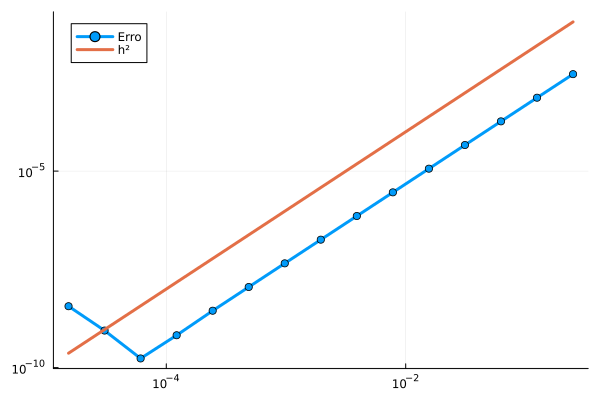

In [19]:
α = 1.0
β = 1.0

n_testes = 16
estudo_convergencia(n_testes, f4, u4, α, β)